In [1]:
import albumentations
import numpy as np
import pandas as pd
import os
import glob
import random
from pprint import pprint
from tqdm import tqdm

# PyTorch Model
import torch
from torch import nn
from torch.nn import functional as F

# Dataset Loading
from PIL import Image
from PIL import ImageFile

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Model Training
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# Configurations for the files
DIR = "/content/drive/MyDrive/Proj_R/training_images" # Replace with your data directory
BATCH_SIZE = 16
IMG_HEIGHT = 75
IMG_WIDTH = 300
EPOCHS = 150
NUM_WORKERS = 8
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
paths = []
labels = []
for image in os.listdir(DIR):
    paths.append(os.path.join(DIR, image))
    labels.append(image.split(".")[0])

df = pd.DataFrame({
    "paths": paths,
    "labels": labels
})

df.head()

,paths,labels
0,/content/drive/MyDrive/Proj_R/training_images/...,axklc
1,/content/drive/MyDrive/Proj_R/training_images/...,km4x6
2,/content/drive/MyDrive/Proj_R/training_images/...,37j5m
3,/content/drive/MyDrive/Proj_R/training_images/...,bgopx
4,/content/drive/MyDrive/Proj_R/training_images/...,ccfpt


In [4]:
def show_random_images(df, column_name):
    f = plt.figure(figsize=(10,10))
    i=1
    for i in range(16):
        i += 1
        ax = f.add_subplot(4,4,i)
        sample = random.choice(df[column_name])
        image = mpimg.imread(sample)
        ax.set_title(sample.split("/")[-1])
        plt.imshow(image)

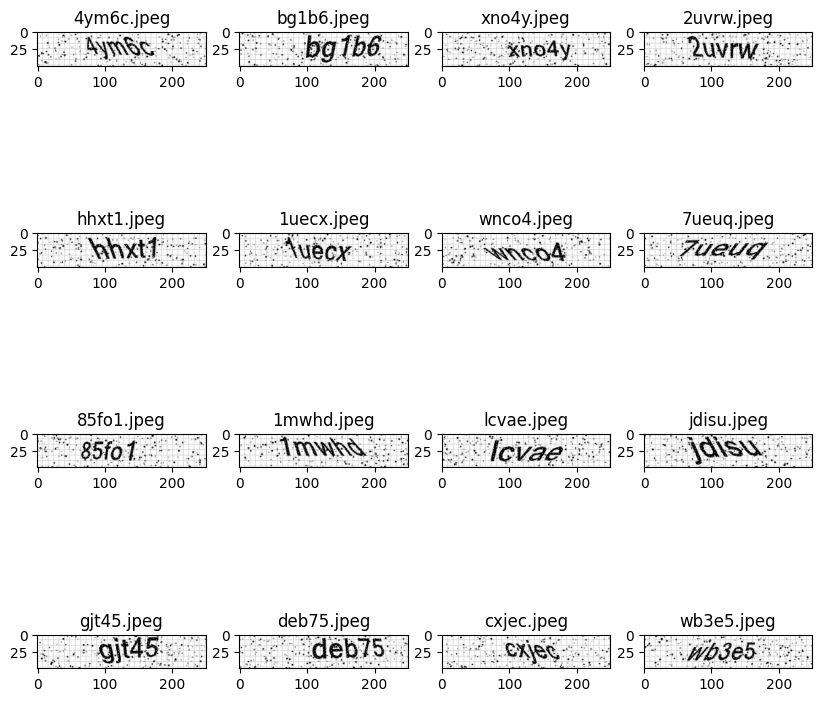

In [5]:
show_random_images(df, "paths")

In [6]:
def get_loss_function(x, bs, targets):
    log_softmax_values = F.log_softmax(x, 2)

    input_lengths = torch.full(
        size=(bs,), fill_value=log_softmax_values.size(0), dtype=torch.int32
    )

    target_lengths = torch.full(
        size=(bs,), fill_value=targets.size(1), dtype=torch.int32
    )

    return nn.CTCLoss(blank=0)(log_softmax_values, targets, input_lengths, target_lengths)

In [7]:
class MyCaptchaModel(nn.Module):
    def __init__(self, num_chars):
        super(MyCaptchaModel, self).__init__()

        # CNN Layer
        self.conv1 = nn.Conv2d(3, 256, kernel_size=(3,3), padding=(1,1))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))

        self.conv2 = nn.Conv2d(256, 128, kernel_size=(3,3), padding=(1,1))
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2))

        self.conv3 = nn.Conv2d(128, 64, kernel_size=(3,3), padding=(1,1))
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2,2))

        # RNN Layer Preprocess
        self.linear1 = nn.Linear(576, 128)  # Adjusted the input size here
        self.drop1 = nn.Dropout(0.2)

        # LSTM GRU
        self.gru = nn.GRU(128, 64, bidirectional=True, num_layers=2, dropout=0.25, batch_first=True)

        self.linear2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, num_chars+1)


    def forward(self, images, targets=None):
        bs, channel, height, width = images.size()

        x = F.relu(self.conv1(images))
        x = self.maxpool1(x)

        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)

        x = F.relu(self.conv3(x))
        x = self.maxpool3(x)

        x = x.permute(0, 3, 1, 2)
        x = x.view(bs, x.size(1), -1)
        x = self.linear1(x)
        x = self.drop1(x)

        x, _ = self.gru(x)
        x = self.linear2(x)
        x = self.output(x)
        x = x.permute(1, 0, 2)

        if targets is not None:
            loss = get_loss_function(x, bs, targets)
            return x, loss

        return x, None


In [8]:
def train_function(model, data_loader, optimizer):
    model.train()
    fin_loss = 0
    tk = tqdm(data_loader, total=len(data_loader))
    for data in tk:
        for k, v in data.items():
            data[k] = v.to(DEVICE)

        optimizer.zero_grad()
        _, loss = model(**data)
        loss.backward()
        optimizer.step()
        fin_loss += loss.item()

    return fin_loss / len(data_loader)


In [9]:
def eval_function(model, data_loader):
    model.eval()
    fin_loss = 0
    fin_preds = []
    with torch.no_grad():
        tk = tqdm(data_loader, total=len(data_loader))
        for data in tk:
            for k, v in data.items():
                data[k] = v.to(DEVICE)

            batch_preds, loss = model(**data)
            fin_loss += loss.item()
            fin_preds.append(batch_preds)

        return fin_preds, fin_loss / len(data_loader)

## Include Alphabets (a-z) and Numeric characters (0-9)

In [10]:
import string

# All possible characters in the captcha
possible_chars = string.ascii_lowercase + string.digits


In [11]:
def encode_targets():
  # Load images from files
  image_files = glob.glob(os.path.join(DIR, "*.jpeg"))
  image_files_png = glob.glob(os.path.join(DIR, "*.png"))
  image_files.extend(image_files_png)
  targets_orig = [x.split("/")[-1].split(".")[0] for x in image_files]
  targets = [[c for c in x] for x in targets_orig]
  targets_flat = [c for clist in targets for c in clist] # squeeze

  # Create a dictionary to map each character to a unique numeric value
  char_to_label = {char: idx for idx, char in enumerate(possible_chars)}

  # Encode images
  targets_enc = [[char_to_label[c] for c in x] for x in targets]
  targets_enc = np.array(targets_enc) + 1 # transform to np and remove 0 index

  return image_files, targets_enc, targets_orig, char_to_label


In [12]:
# Train-test split
image_files, targets_enc, targets_orig, lbl_enc = encode_targets()

(train_imgs, test_imgs, train_targets, test_targets, _, test_orig_targets) = train_test_split(
    image_files, targets_enc, targets_orig, test_size=0.1, random_state=0)

In [13]:
ImageFile.LoadTruncatedImages = True

class DatasetClassifier:
    def __init__(self, image_paths, targets, resize=None):
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        self.aug = albumentations.Compose(
            [
             albumentations.Normalize(always_apply=True)
            ]
            )

    def __len__(self):
       return len(self.image_paths)

    def __getitem__(self, item):
        image = Image.open(self.image_paths[item]).convert("RGB")
        target = self.targets[item]

        if self.resize is not None:
            image = image.resize((self.resize[1], self.resize[0]), resample=Image.BILINEAR)

        image = np.array(image)
        augmented = self.aug(image=image)
        image = augmented["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)

        return {
            "images": torch.tensor(image, dtype=torch.float),
            "targets": torch.tensor(target, dtype=torch.long)
        }

In [14]:
# Classify images, load using pytorch's DataLoader
train_dataset = DatasetClassifier(
    image_paths=train_imgs, targets=train_targets, resize=(IMG_HEIGHT, IMG_WIDTH)
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)

test_dataset = DatasetClassifier(
    image_paths=test_imgs, targets=test_targets, resize=(IMG_HEIGHT, IMG_WIDTH)
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [15]:
# Load the models
model = MyCaptchaModel(num_chars=len(possible_chars))
model.to(DEVICE)

# Create optimizer and callbacks
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.8, patience=5, verbose=True
)

In [16]:
def early_stopping(patience, count, prev_loss, current_loss, threshold):
    if abs(prev_loss - current_loss) < threshold and count >= patience:
        return "stop"
    elif abs(prev_loss - current_loss) < threshold:
        return "count"
    else:
        return False

In [17]:
def decode_predictions(preds, char_to_label):
    preds = preds.permute(1, 0, 2)
    preds = torch.softmax(preds, 2)
    preds = torch.argmax(preds, 2)
    preds = preds.detach().cpu().numpy()
    cap_preds = []
    label_to_char = {v: k for k, v in char_to_label.items()}
    for j in range(preds.shape[0]):
        temp = []
        for k in preds[j,:]:
            k = k - 1
            if k == -1:
                temp.append("-")
            else:
                temp.append(label_to_char[k])
        tp = "".join(temp)
        cap_preds.append(tp)
    return cap_preds


In [29]:
patience = 15
count = 0
prev_train_loss = 0
threshold = 0.009
loss = []

for epoch in range(EPOCHS):
    train_loss = train_function(model, train_loader, optimizer)
    valid_preds, valid_loss = eval_function(model, test_loader)
    valid_cap_preds = []

    for vp in valid_preds:
        current_preds = decode_predictions(vp, lbl_enc)
        valid_cap_preds.extend(current_preds)

    pprint(list(zip(test_orig_targets, valid_cap_preds))[15:20])
    print(f"Epoch: {epoch}, train_loss: {train_loss}, valid_loss: {valid_loss}")
    res = early_stopping(patience, count, prev_train_loss, train_loss, threshold)

    loss.append(train_loss)

    if res == "stop":
        print("Early Stopping Implemented.")
        final_epoch = epoch
        break
    elif res == "count" and train_loss < 0.2:
        count += 1
        print(f"Patience at {patience-count}")
    else:
        prev_train_loss = train_loss

  0%|          | 0/138 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 16/16 [00:01<00:00, 11.43it/s]


[('7yegx', '----------77--y--e--g---------------x'),
 ('kr5s7', '----------k--r--5---s---------------7'),
 ('jxb14', '----------j-x---b--1----------------4'),
 ('o27ry', '-------------o--2--77--r------------y'),
 ('msnph', '---------------m--s---n--p----------h')]
Epoch: 0, train_loss: 0.018952966996289764, valid_loss: 0.1483727931845351


100%|██████████| 16/16 [00:01<00:00, 11.93it/s]


[('7yegx', '----------77--y--e--g---------------x'),
 ('kr5s7', '----------k--r--5---s---------------7'),
 ('jxb14', '----------j-x---b--1----------------4'),
 ('o27ry', '-------------o--22-77-rr------------y'),
 ('msnph', '---------------m--s---n--p----------h')]
Epoch: 1, train_loss: 0.016837274157560256, valid_loss: 0.1828476777591277
Patience at 14


100%|██████████| 16/16 [00:01<00:00, 12.17it/s]


[('7yegx', '----------77--y--e--g---------------x'),
 ('kr5s7', '----------k--r--5---s---------------7'),
 ('jxb14', '----------j-x---b--1----------------4'),
 ('o27ry', '-------------o--22-77-rr------------y'),
 ('msnph', '---------------mm-s---n--p----------h')]
Epoch: 2, train_loss: 0.009966130534809528, valid_loss: 0.1396579803840723
Patience at 13


100%|██████████| 16/16 [00:01<00:00, 11.41it/s]


[('7yegx', '----------77--v--e--g---------------x'),
 ('kr5s7', '----------k--r--5---s---------------7'),
 ('jxb14', '----------j-x---b--1----------------4'),
 ('o27ry', '-------------o--22-77-rr------------y'),
 ('msnph', '---------------m--s---n--p----------h')]
Epoch: 3, train_loss: 0.007834000587615225, valid_loss: 0.13568744872463867


100%|██████████| 16/16 [00:01<00:00, 11.67it/s]


[('7yegx', '----------77--y--e--g---------------x'),
 ('kr5s7', '----------k--r--5---s---------------7'),
 ('jxb14', '----------j-x---b-11----------------4'),
 ('o27ry', '-------------o--2--77-rr------------y'),
 ('msnph', '---------------mm-s---n--p----------h')]
Epoch: 4, train_loss: 0.010055860904158444, valid_loss: 0.14757690624992392
Patience at 12


100%|██████████| 16/16 [00:01<00:00, 10.62it/s]


[('7yegx', '----------77--y--e--g---------------x'),
 ('kr5s7', '----------k--r--5---s---------------7'),
 ('jxb14', '----------j-x---b--1----------------4'),
 ('o27ry', '-------------o--2--77-rr------------y'),
 ('msnph', '---------------mm-s---n--p----------h')]
Epoch: 5, train_loss: 0.004319372906520848, valid_loss: 0.13404214182628493
Patience at 11


100%|██████████| 16/16 [00:01<00:00,  9.02it/s]


[('7yegx', '----------77--y--e--g---------------x'),
 ('kr5s7', '----------k--r--5---s---------------7'),
 ('jxb14', '----------j-x---b-11----------------4'),
 ('o27ry', '-------------o--2--77-rr------------y'),
 ('msnph', '---------------mm-ss-nn--p----------h')]
Epoch: 6, train_loss: 0.009815691895209307, valid_loss: 0.13988018389500212
Patience at 10


100%|██████████| 16/16 [00:01<00:00,  8.45it/s]


[('7yegx', '----------77--y--e--g---------------x'),
 ('kr5s7', '----------k--r--5---s---------------7'),
 ('jxb14', '----------j-x---b--1----------------4'),
 ('o27ry', '------------oo--2--77-rr------------y'),
 ('msnph', '---------------mm-ss--n--p----------h')]
Epoch: 7, train_loss: 0.009692604281936192, valid_loss: 0.13531354602309875
Patience at 9


100%|██████████| 16/16 [00:01<00:00,  8.22it/s]


[('7yegx', '----------77--y--e--g---------------x'),
 ('kr5s7', '----------k--r--5---s---------------7'),
 ('jxb14', '----------j-x---b--1----------------4'),
 ('o27ry', '------------oo--2--77-rr------------y'),
 ('msnph', '---------------m--s---n--p----------h')]
Epoch: 8, train_loss: 0.003948370060770421, valid_loss: 0.13053627002955182
Patience at 8


100%|██████████| 16/16 [00:01<00:00,  8.31it/s]


[('7yegx', '----------77--y--e--g---------------x'),
 ('kr5s7', '----------k--r--5---s---------------7'),
 ('jxb14', '----------j-x---b--1----------------4'),
 ('o27ry', '------------oo--2--77-rr------------y'),
 ('msnph', '---------------mm-s---n--p----------h')]
Epoch: 9, train_loss: 0.007779953787035808, valid_loss: 0.11468999079079367
Patience at 7


100%|██████████| 16/16 [00:01<00:00,  8.27it/s]


[('7yegx', '----------77--v--e--g---------------x'),
 ('kr5s7', '----------k-rr--5---s---------------7'),
 ('jxb14', '----------j-x---b--1----------------4'),
 ('o27ry', '------------oo--2--77--r------------y'),
 ('msnph', '---------------m--s---n--p----------h')]
Epoch: 10, train_loss: 0.01996875316452107, valid_loss: 0.144952181228291


100%|██████████| 16/16 [00:02<00:00,  8.00it/s]


[('7yegx', '----------77--y--e--g---------------x'),
 ('kr5s7', '----------k--r--5---s---------------7'),
 ('jxb14', '----------j-x---b--1----------------4'),
 ('o27ry', '-------------o--2--77-rr------------y'),
 ('msnph', '---------------mm-s---n--p----------h')]
Epoch: 11, train_loss: 0.009978434399522814, valid_loss: 0.13322199932008516


100%|██████████| 16/16 [00:01<00:00,  8.13it/s]


[('7yegx', '----------77--y--e--g---------------x'),
 ('kr5s7', '----------k--r--5---s---------------7'),
 ('jxb14', '----------j-x---b--1----------------4'),
 ('o27ry', '-------------o--2--77--r------------y'),
 ('msnph', '---------------mm-s---n--p----------h')]
Epoch: 12, train_loss: 0.012968090883130546, valid_loss: 0.17383869411423802
Patience at 6


100%|██████████| 16/16 [00:01<00:00,  8.28it/s]


[('7yegx', '----------77--y--e--g---------------x'),
 ('kr5s7', '----------k-rr--5---s---------------7'),
 ('jxb14', '----------j-x---b--1----------------4'),
 ('o27ry', '------------oo--2--77--r------------y'),
 ('msnph', '---------------mm-s---n--p----------h')]
Epoch: 13, train_loss: 0.011454403420878183, valid_loss: 0.14638963429024443
Patience at 5


100%|██████████| 16/16 [00:01<00:00,  8.13it/s]


[('7yegx', '----------77--y--e--g---------------x'),
 ('kr5s7', '----------k--r--5---s---------------7'),
 ('jxb14', '----------j-x---b-11----------------4'),
 ('o27ry', '-------------o--2--77--r------------y'),
 ('msnph', '---------------mm-s---n--p----------h')]
Epoch: 14, train_loss: 0.007469566338366586, valid_loss: 0.13770109613324166
Patience at 4


100%|██████████| 16/16 [00:02<00:00,  8.00it/s]


[('7yegx', '----------77--y--e--g---------------x'),
 ('kr5s7', '----------k--r--5---s---------------7'),
 ('jxb14', '----------j-x---b--1----------------4'),
 ('o27ry', '-------------o--2--77--r------------y'),
 ('msnph', '---------------mm-s---n--p----------h')]
Epoch: 15, train_loss: 0.009287981438978602, valid_loss: 0.15304058846959379
Patience at 3


100%|██████████| 16/16 [00:02<00:00,  7.95it/s]


[('7yegx', '----------77--v--e--g---------------x'),
 ('kr5s7', '----------k--r--5---s---------------7'),
 ('jxb14', '----------j-x---b--1----------------4'),
 ('o27ry', '------------oo--2--77--r------------y'),
 ('msnph', '---------------m--s---n--p----------h')]
Epoch: 16, train_loss: 0.016377902558631013, valid_loss: 0.15146090803318657
Patience at 2


100%|██████████| 16/16 [00:02<00:00,  7.87it/s]


[('7yegx', '----------77--y--e--g---------------x'),
 ('kr5s7', '----------k--r--5---s---------------7'),
 ('jxb14', '----------j-x---b-11----------------4'),
 ('o27ry', '-------------o--2--77--r------------y'),
 ('msnph', '---------------m--s---n--p----------h')]
Epoch: 17, train_loss: 0.015895548137410988, valid_loss: 0.1897643784786851
Patience at 1


100%|██████████| 16/16 [00:02<00:00,  7.29it/s]


[('7yegx', '----------77--v--e--g---------------x'),
 ('kr5s7', '----------k--r--5---s---------------7'),
 ('jxb14', '----------j-x---b--1----------------4'),
 ('o27ry', '------------oo--2--77--r------------y'),
 ('msnph', '---------------m--s---n--p----------h')]
Epoch: 18, train_loss: 0.012136004360492234, valid_loss: 0.12241499404262868
Patience at 0


100%|██████████| 16/16 [00:02<00:00,  7.63it/s]

[('7yegx', '----------77--y--e--g---------------x'),
 ('kr5s7', '----------k--r--5---s---------------7'),
 ('jxb14', '----------j-x---b--1----------------4'),
 ('o27ry', '------------oo--2--77--r------------y'),
 ('msnph', '---------------m--s---n--p----------h')]
Epoch: 19, train_loss: 0.009709410048305037, valid_loss: 0.1154720823833486
Early Stopping Implemented.


<Axes: title={'center': 'Loss During Epoch Training'}, xlabel='Epoch No.', ylabel='Loss Value'>

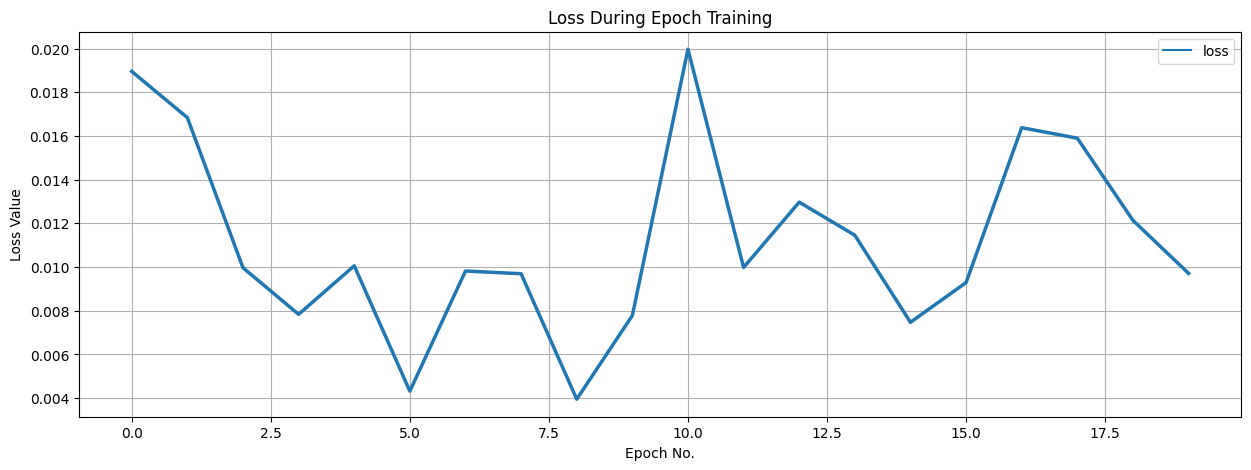

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

df_pytorch = pd.DataFrame({"loss": loss})
plt.figure(figsize=(15,5))
plt.grid()
plt.xlabel("Epoch No.")
plt.ylabel("Loss Value")
plt.title("Loss During Epoch Training")
sns.lineplot(data=df_pytorch, palette="tab10", linewidth=2.5)

In [31]:
def get_image(image_path=None):
    if image_path == None:
        img = random.choice(df["paths"])
        return [img]
    return [image_path]


def get_sample_photo(image_path=None):
    img = get_image(image_path)
    eval_dataset = DatasetClassifier(
        image_paths=img, targets=[np.array([x for x in np.arange(10)])], resize=(IMG_HEIGHT, IMG_WIDTH)
    )

    eval_loader = torch.utils.data.DataLoader(
        eval_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        shuffle=False
    )

    return img, eval_loader


def predict_function(model, data_loader):
    model.eval()
    fin_preds = []
    with torch.no_grad():
        for data in data_loader:
            for k, v in data.items():
                data[k] = v.to(DEVICE)

            batch_preds, _ = model(**data)
            fin_preds.append(batch_preds)

        return fin_preds

In [32]:
image_path, eval_loader = get_sample_photo()
print(image_path)

def clean_decoded_predictions(unclean_predictions):
    cleaned_predictions = []
    for i in unclean_predictions:
        if i != "-":
            cleaned_predictions.append(i)

    cleaned_predictions = "".join(cleaned_predictions)

    if len(cleaned_predictions) == 10:
        return cleaned_predictions

    else:
        prev = "-"
        new_cleaned_predictions = []
        for char in cleaned_predictions:
            if char == prev:
                continue
            new_cleaned_predictions.append(char)
            prev = char
        res = "".join(new_cleaned_predictions)
        return res

def predict_captcha(model, eval_loader, image_path):
    plt.figure(figsize=(15,5))
    image = mpimg.imread(image_path[0])
    target = image_path[0].split("/")[-1].split(".")[0]
    plt.title(image_path[0].split("/")[-1])
    plt.imshow(image)

    valid_preds = predict_function(model, eval_loader)
    for vp in valid_preds:
        current_preds = decode_predictions(vp, lbl_enc)

    preds = clean_decoded_predictions(current_preds[0])

    success = True if preds == target else False

    return{
        "success": success,
        "prediction": preds,
        "real": target
    }

['/content/drive/MyDrive/Proj_R/training_images/df358.jpeg']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Testing

{'success': True, 'prediction': 'df358', 'real': 'df358'}

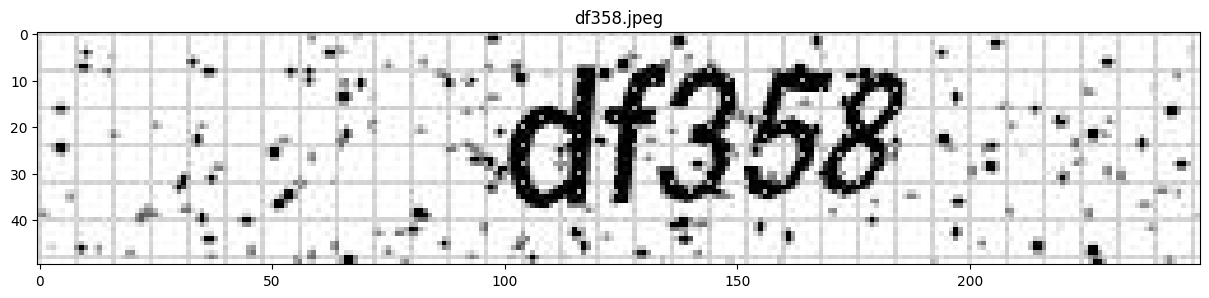

In [33]:
preds = predict_captcha(model, eval_loader, image_path)
preds

In [34]:
import torch

# Assuming 'model' is your trained model
torch.save(model.state_dict(), 'model_new.pth')